# Import libraries

In [1]:
import os
import sys

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns


Missing colon in file '/Users/jamesli/.matplotlib/matplotlibrc', line 1 ('TkAgg')


In [2]:
import celloracle as co

In [3]:
plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = [9,6]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 600

%matplotlib inline

## 0.1. Make a folder to save graph

In [4]:
# Make folder to save plots
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

# 1. Load data
## 1.1. Load processed oracle object

Load the oracle object (in-house E12.5 scRNA-seq) that was created previously.

In [5]:
oracle = co.load_hdf5("data/E12.celloracle.oracle")

## 1.2. Load inferred GRNs

Load previously generated GRNs based on integrated snATAC-seq and scRNA-seq of E12.5 mouse cerebellum. 

In [6]:
links = co.load_hdf5("data/links_umap.celloracle.links")

# 2. Make predictive models for simulation

Fit ridge regression models.

In [7]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

fitting GRN again...
calculating GRN in CN_Th



genes_in_gem: 3000
models made for 808 genes
calculating GRN in CN_early1



genes_in_gem: 3000
models made for 759 genes
calculating GRN in CN_early2



genes_in_gem: 3000
models made for 827 genes
calculating GRN in CN_gaba



genes_in_gem: 3000
models made for 835 genes
calculating GRN in CN_late



genes_in_gem: 3000
models made for 798 genes
calculating GRN in Endothelium



genes_in_gem: 3000
models made for 964 genes
calculating GRN in Eryth



genes_in_gem: 3000
models made for 615 genes
calculating GRN in GABA_Pre



genes_in_gem: 3000
models made for 741 genes
calculating GRN in GABA_Pro



genes_in_gem: 3000
models made for 779 genes
calculating GRN in IN



genes_in_gem: 3000
models made for 714 genes
calculating GRN in Leptomeningeal cell



genes_in_gem: 3000
models made for 824 genes
calculating GRN in Mes.Isl1



genes_in_gem: 3000
models made for 773 genes
calculating GRN in Microglia



genes_in_gem: 3000
models made for 802 genes
calculating GRN in NPC



genes_in_gem: 3000
models made for 813 genes
calculating GRN in NPC_cyc



genes_in_gem: 3000
models made for 795 genes
calculating GRN in NPCa



genes_in_gem: 3000
models made for 811 genes
calculating GRN in PC



genes_in_gem: 3000
models made for 811 genes
calculating GRN in PTZ



genes_in_gem: 3000
models made for 792 genes
calculating GRN in Pericytes



genes_in_gem: 3000
models made for 846 genes
calculating GRN in RL



genes_in_gem: 3000
models made for 800 genes
calculating GRN in X_Otp



genes_in_gem: 3000
models made for 837 genes
calculating GRN in X_Otp_Pre



genes_in_gem: 3000
models made for 760 genes
calculating GRN in X_Tlx3



genes_in_gem: 3000
models made for 833 genes


# 3. in silico Perturbation-simulation

In [14]:
co.network_analysis.gene_analysis.settings["save_figure_as"] = "pdf" 
co.network_analysis.network_structure_analysis.settings["save_figure_as"] = "pdf"

In [15]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Here, we simulate gene knockout of Hes1, Hes5, Ptf1a, or Atoh1 on cell fate specification, by setting it expression level to 0.0.

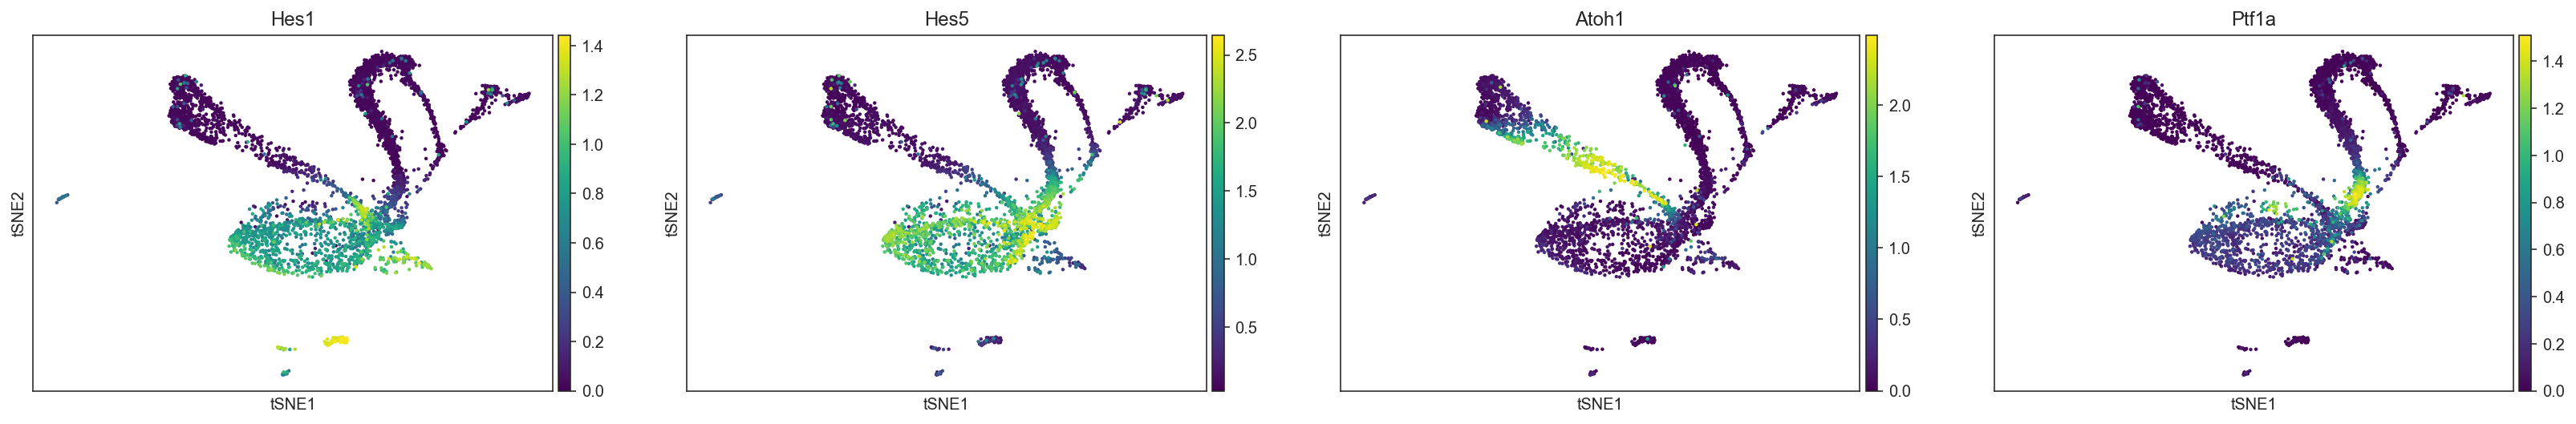

In [37]:
sc.pl.tsne(oracle.adata, color=['Hes1','Hes5','Atoh1','Ptf1a'],
                 layer="imputed_count", use_raw=False, cmap="viridis",save=f'{save_folder}/_GOIs')

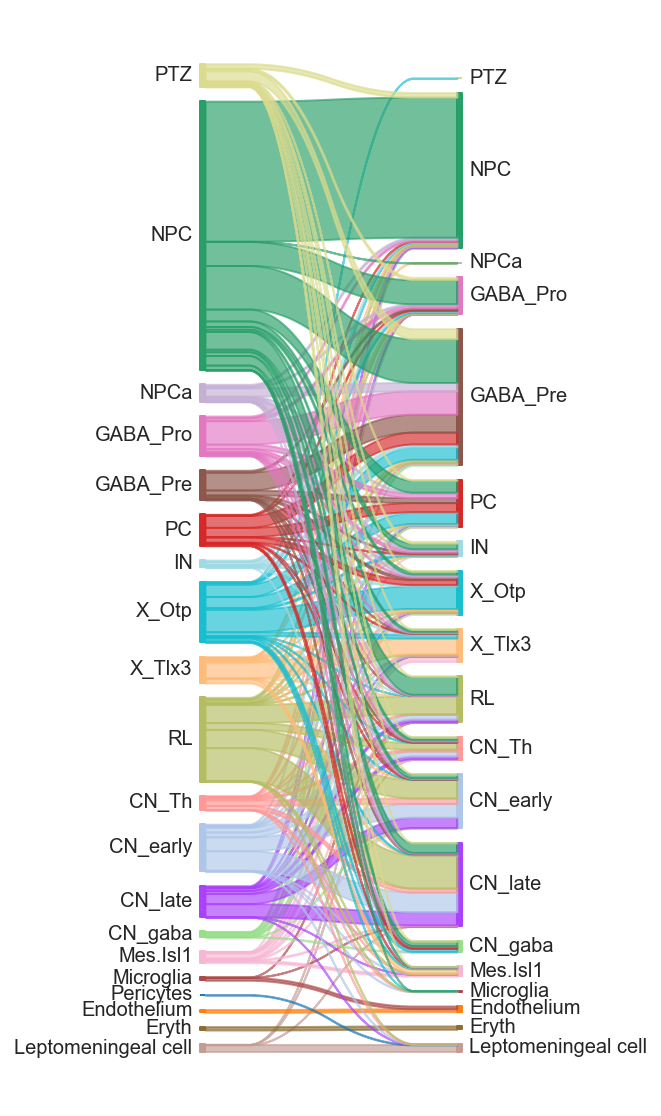

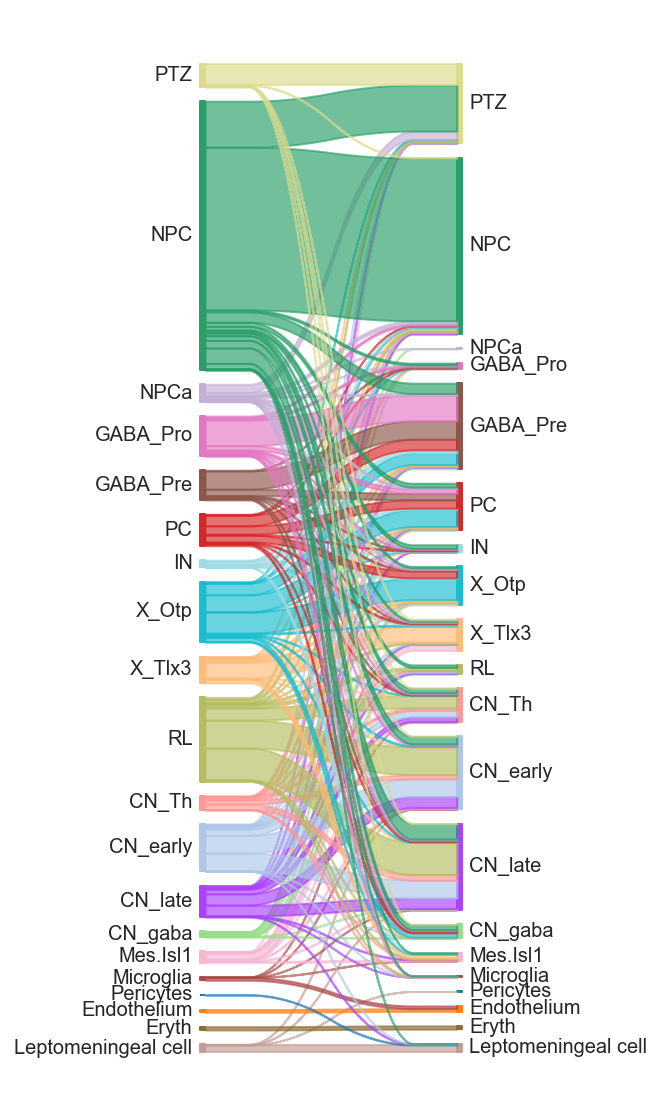

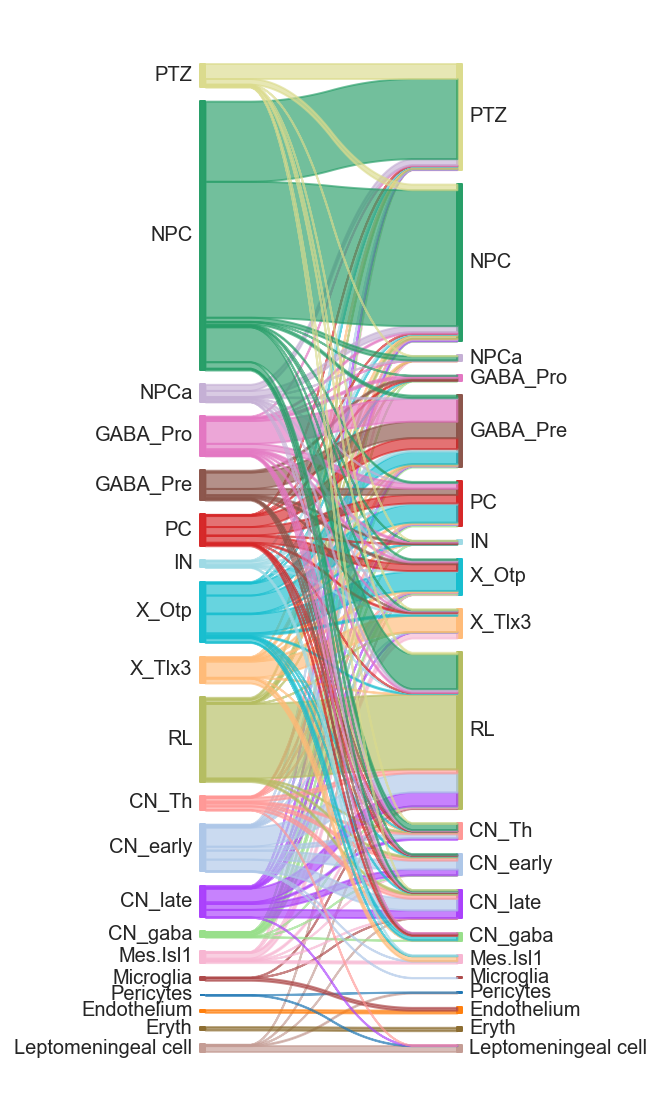

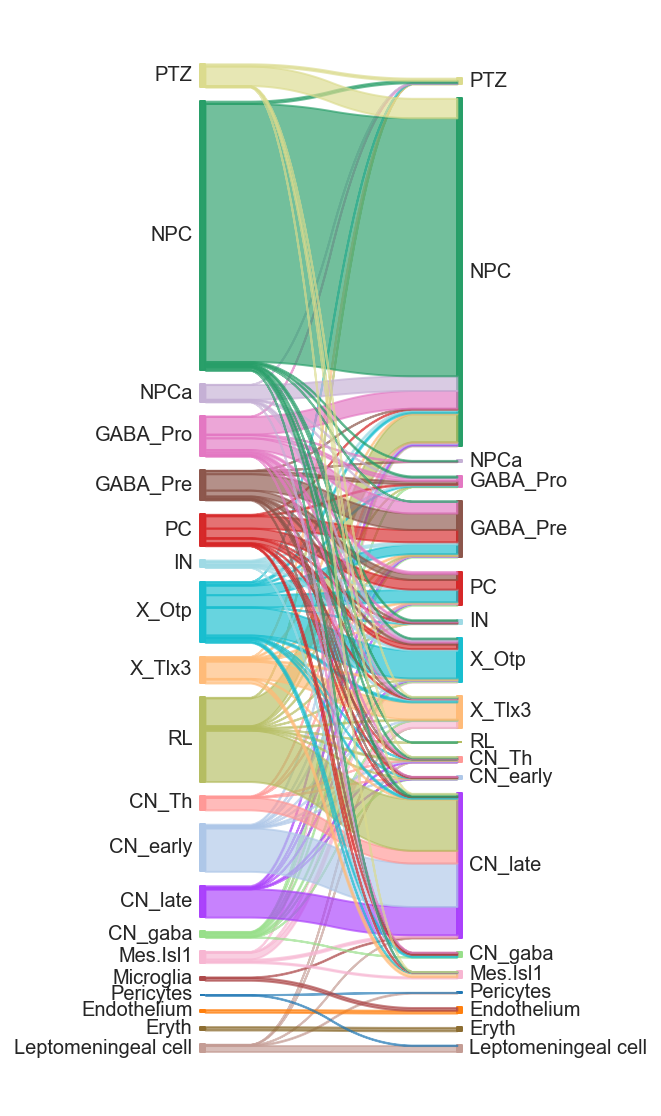

In [16]:
genes = ['Hes1','Hes5','Ptf1a','Atoh1']

cl = "cellGroup"
order = ["PTZ",'NPC', 'NPCa','GABA_Pro', 'GABA_Pre', 'PC', 'IN', 'X_Otp', 'X_Otp_Pre', 'X_Tlx3','RL','CN_Th', 'CN_early', 'CN_late','CN_gaba', 'Mes.Isl1', 'Microglia', 'Pericytes','Endothelium', 'Eryth', 'Leptomeningeal cell']
# Check gene expression 
for goi in genes:
    # Enter perturbation conditions to simulate signal propagation after the perturbation.
    oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=5)

    # Get transition probability
    oracle.estimate_transition_prob(n_neighbors=200, knn_random=True, sampled_fraction=0.5)

    # Calculate embedding 
    oracle.calculate_embedding_shift(sigma_corr = 0.05)

    # Calculate global trend of cell transition
    oracle.calculate_grid_arrows(smooth=0.8, steps=(40, 40), n_neighbors=300)

    ## Perform Markov simulation
    oracle.run_markov_chain_simulation(n_steps=200, n_duplication=5)

    # Summarize results in a sankey diagram 
    plt.figure(figsize=[5,10])
    plt.subplots_adjust(left=0.3, right=0.7)
    oracle.plot_mc_resutls_as_sankey(cluster_use=cl, start=0, end=-1, order=order)
    plt.savefig(f"{save_folder}/simulation/mcmc_{goi}_cellGroup.pdf")

# Simulate double KO of Hes1 and Hes5
Here we simulate double KO of Hes1 and Hes5. 

In [17]:
#DKO of Hes1 and Hes5
# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={'Hes1': 0.0, 'Hes5':0.0},
                      n_propagation=5)

Make another Saneky diagram with different cluster units.

In [18]:
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200, knn_random=True, sampled_fraction=0.5)

# Calculate embedding 
oracle.calculate_embedding_shift(sigma_corr = 0.05)

# Calculate global trend of cell transition
oracle.calculate_grid_arrows(smooth=0.8, steps=(40, 40), n_neighbors=300)

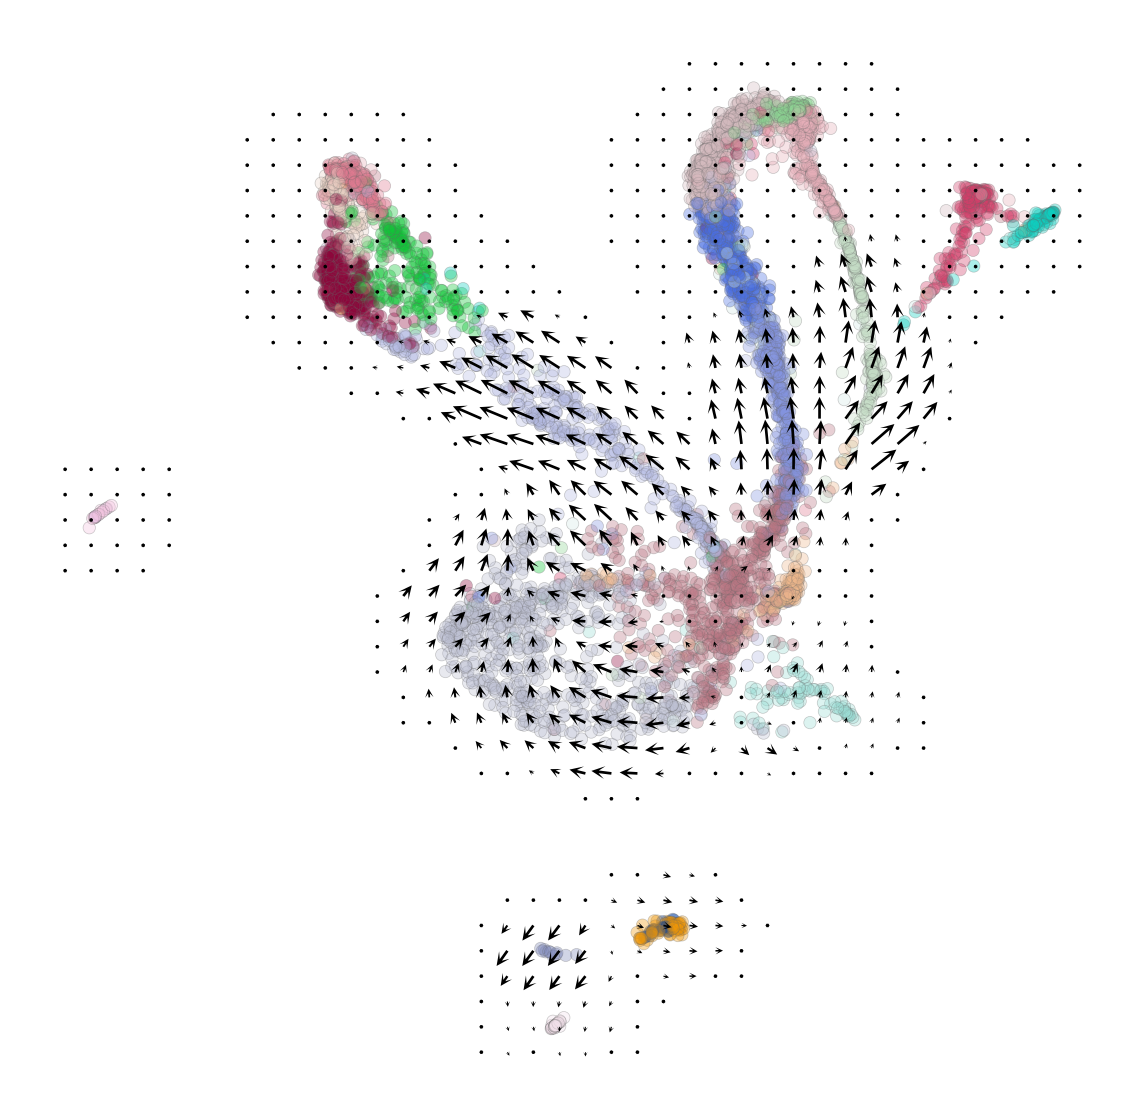

In [19]:
# Plot whole graph
plt.figure(None,(10,10))
oracle.plot_grid_arrows(quiver_scale=2.0,
                        scatter_kwargs_dict={"alpha":0.35, "lw":0.35, 
                                              "edgecolor":"0.4", "s":38, 
                                              "rasterized":True},
                        min_mass=0.015, angles='xy', scale_units='xy',
                        headaxislength=2.75,
                        headlength=5, headwidth=4.8, minlength=1.5,
                        plot_random=False, scale_type="relative")
plt.savefig(f"{save_folder}/simulation/vectorfield_Hes_dKO.pdf", transparent=True)

In [20]:
%%time
# n_steps is the number of steps in markov simulation. 
# n_duplication is the number of technical duplication for the simulation
oracle.run_markov_chain_simulation(n_steps=200, n_duplication=5)

CPU times: user 4.04 s, sys: 57.5 ms, total: 4.1 s
Wall time: 3.89 s


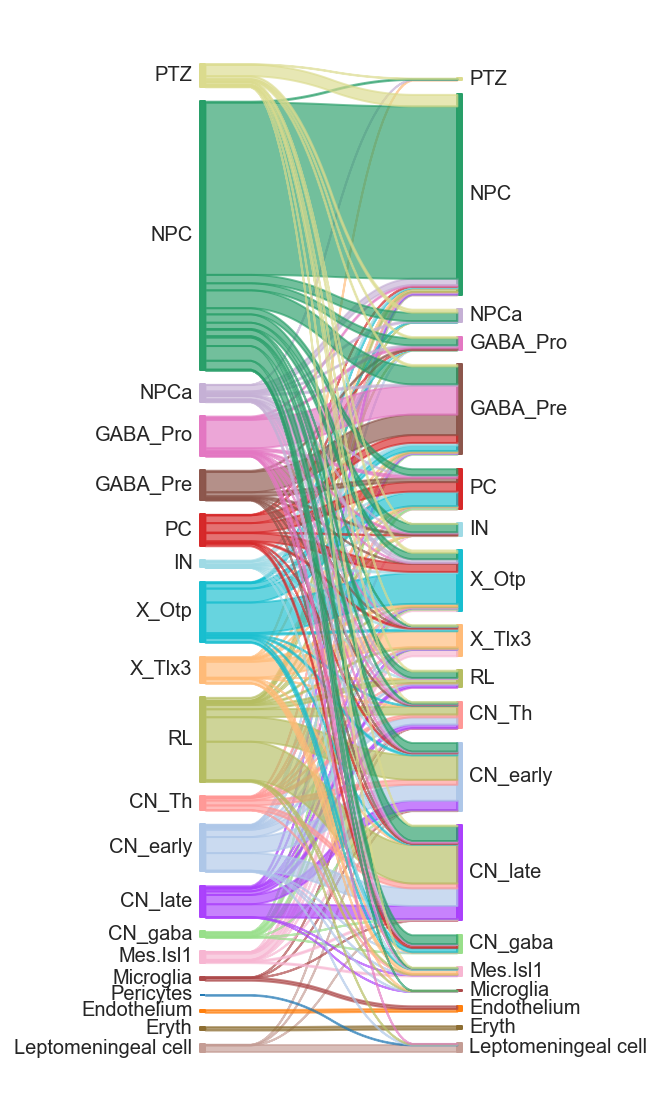

In [21]:
# Plot sankey diagram 
plt.figure(figsize=[5,10])
plt.subplots_adjust(left=0.3, right=0.7)
oracle.plot_mc_resutls_as_sankey(cluster_use=cl, start=0, end=100, order=order)
plt.savefig(f"{save_folder}/simulation/mcmc__Hes_dKO.pdf")

# GOF analysis
Here, we simulate gain-of-function experiment by increasing 2 fold of the endogenous Hes1, Hes5, Ptf1a, or Atoh1.

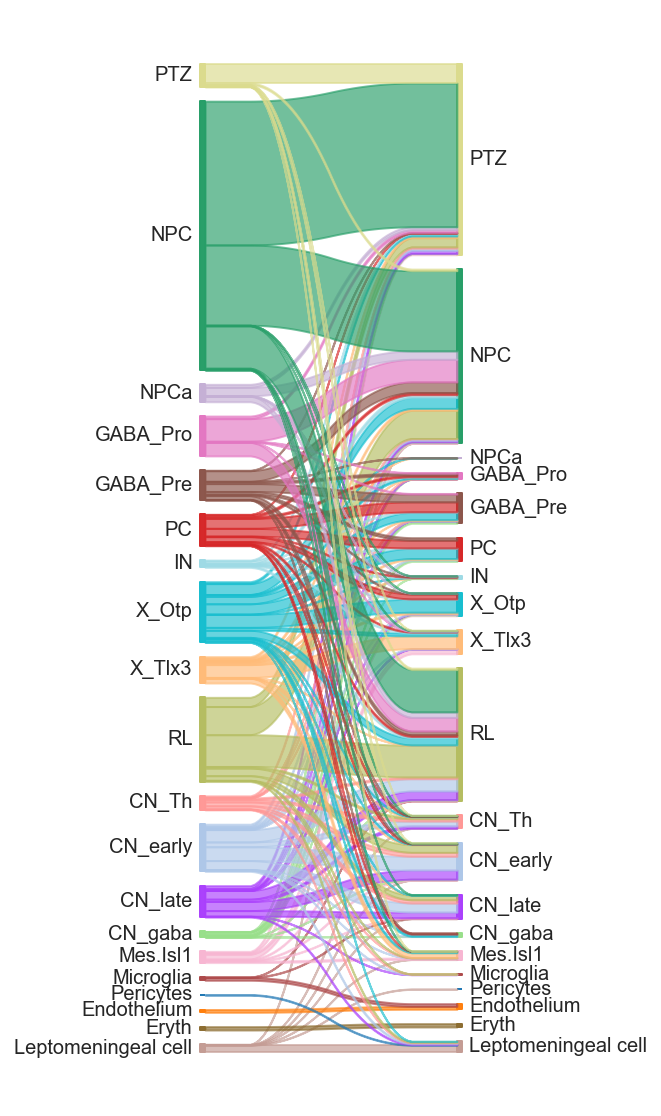

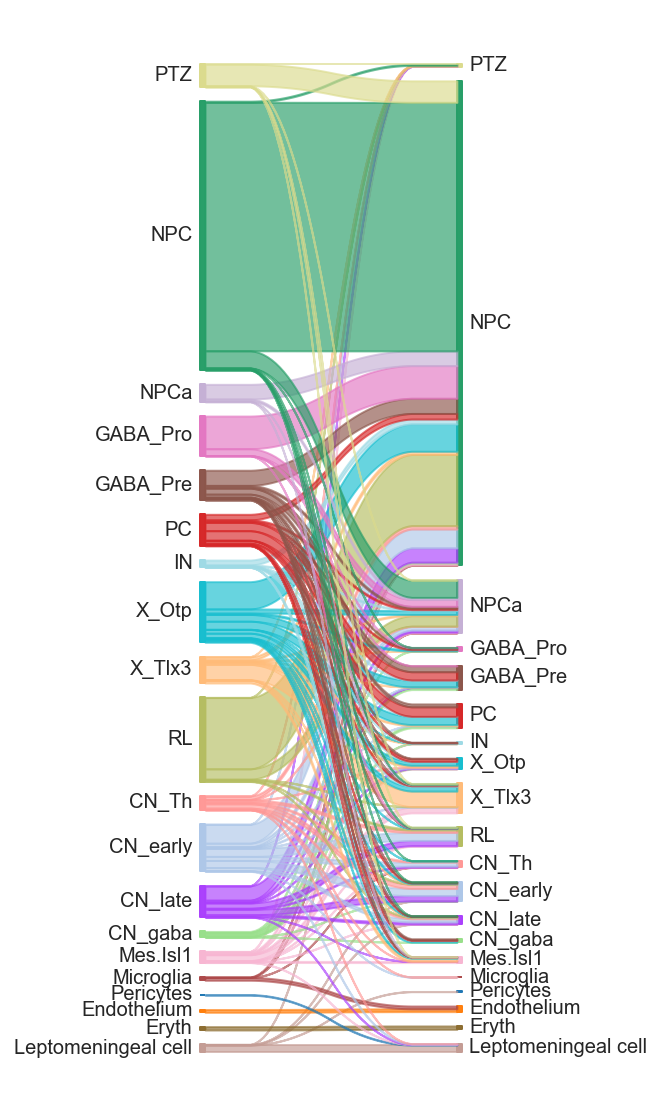

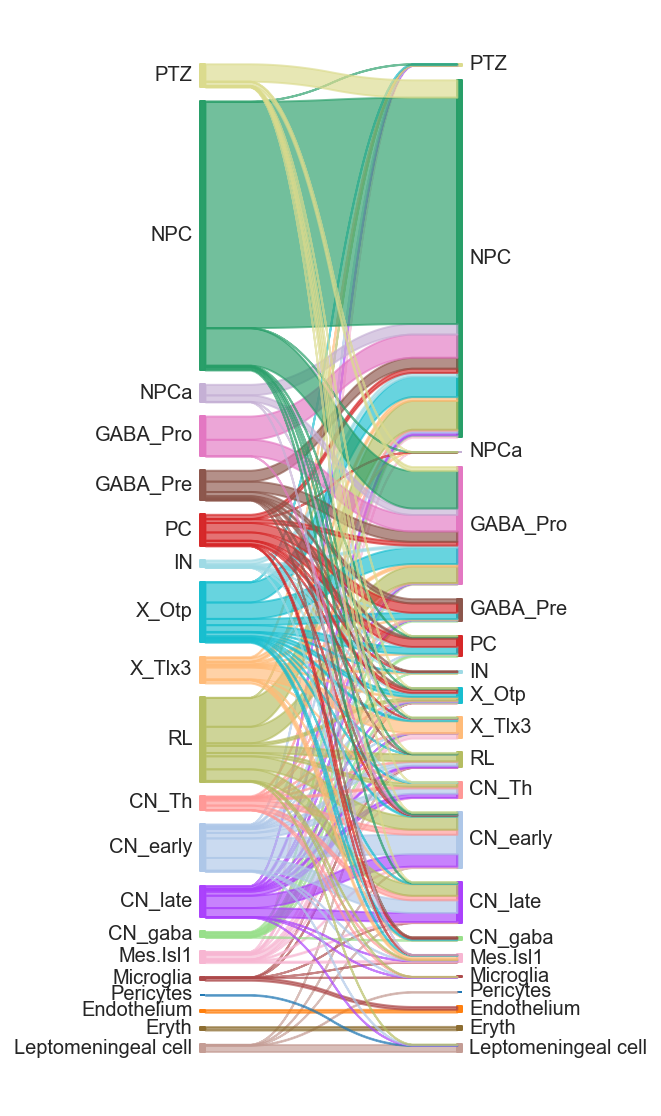

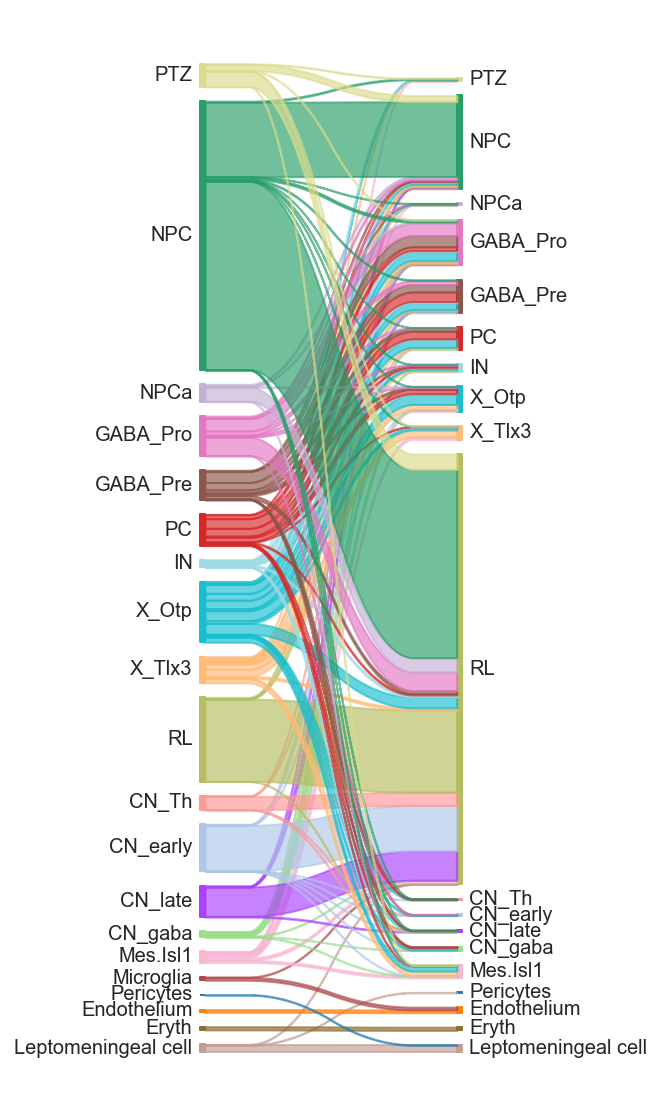

In [35]:
genes = ['Hes1','Hes5','Ptf1a','Atoh1']

cl = "cellGroup"
order = ["PTZ",'NPC', 'NPCa','GABA_Pro', 'GABA_Pre', 'PC', 'IN', 'X_Otp', 'X_Otp_Pre', 'X_Tlx3','RL','CN_Th', 'CN_early', 'CN_late','CN_gaba', 'Mes.Isl1', 'Microglia', 'Pericytes','Endothelium', 'Eryth', 'Leptomeningeal cell']
# Check gene expression 
for goi in genes:
    # set the level to 2 fold of the maximal level
    level=2*sc.get.obs_df(oracle.adata, keys=[goi], layer="imputed_count").max()[goi]
    
    
    # Enter perturbation conditions to simulate signal propagation after the perturbation.
    oracle.simulate_shift(perturb_condition={goi: level},
                      n_propagation=5)

    # Get transition probability
    oracle.estimate_transition_prob(n_neighbors=200, knn_random=True, sampled_fraction=0.5)

    # Calculate embedding 
    oracle.calculate_embedding_shift(sigma_corr = 0.05)

    # Calculate global trend of cell transition
    oracle.calculate_grid_arrows(smooth=0.8, steps=(40, 40), n_neighbors=300)

    ## Perform Markov simulation
    oracle.run_markov_chain_simulation(n_steps=200, n_duplication=5)

    # Summarize results in a sankey diagram 
    plt.figure(figsize=[5,10])
    plt.subplots_adjust(left=0.3, right=0.7)
    oracle.plot_mc_resutls_as_sankey(cluster_use=cl, start=0, end=-1, order=order)
    plt.savefig(f"{save_folder}/simulation/mcmc_{goi}-GOF.pdf")

# Simulate ectopic expression of Atoh1 from the Ptf1a locus, or vice versa
Here, we simulate two knock-in experiments, in which Atoh1 is knockd into the Ptf1a locus, or vice versa. To this end, we calculate the sum of the expression of Ptf1a and Atoh1, and added to either Ptf1a (ectopic Ptf1a) or Atoh1 (ectopic Atoh1).

In [112]:
# load the Atoh1-GOF object
adata=sc.read("data/E12_GOF_Atoh1.h5ad")

In [101]:
# TF data from scATAC-seq of the mouse cerebellum from E!2-E14
TFinfo_df = pd.read_parquet("data/TFinfo_dataframe.parquet")

# Check data
TFinfo_df.head()

peak_id gene_short_name  9430076c15rik  Ac002126.6  \
0  chr10_100004434_100004934            Kitl            0.0         0.0   
1  chr10_100015536_100016036          Cep290            0.0         0.0   
2  chr10_100015536_100016036            Kitl            0.0         0.0   
3  chr10_100015536_100016036           Tmtc3            0.0         0.0   
4  chr10_100016814_100017314            Kitl            0.0         0.0   

   Ac012531.1  Ac226150.2  Afp  Ahr  Ahrr  Aire  ...  Znf784  Znf8  Znf816  \
0         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
1         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
2         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
3         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
4         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   

   Znf85  Zscan10  Zscan16  Zscan22  Zscan26  Zscan31  Zscan4  
0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
1    0.0      0.0      0.0      0.0      0.0      1.0     0.0  
2    0.0      0.0      0.0      0.0      0.0      1.0     0.0  
3    0.0      0.0      0.0      0.0      0.0      1.0     0.0  
4    0.0      0.0      0.0      0.0      0.0      0.0     0.0  

[5 rows x 1092 columns]

In [113]:
oracle = co.Oracle()

oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="cellType",
                                   embedding_name="X_tsne")
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=TFinfo_df)

31


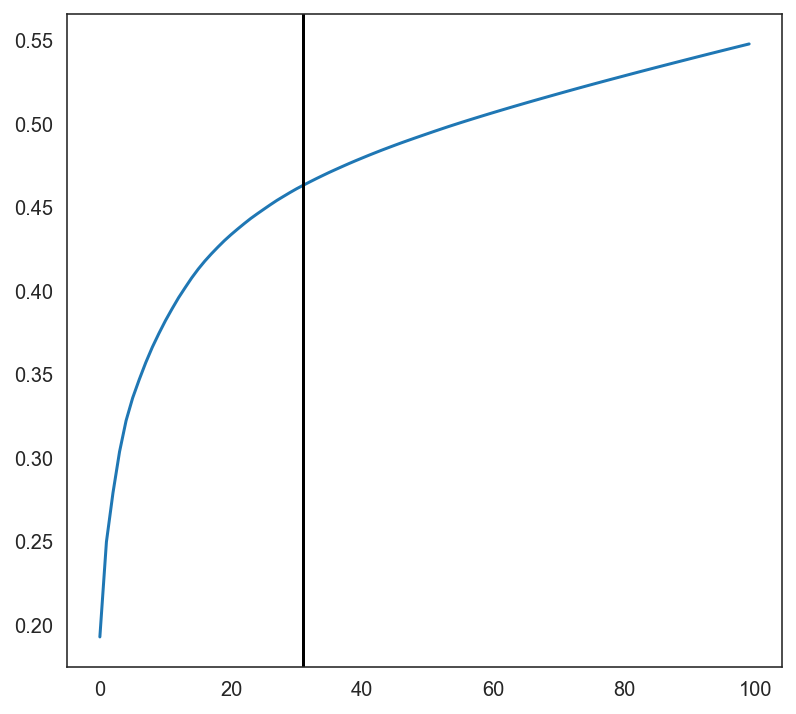

In [114]:
# Perform PCA
oracle.perform_PCA()
# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
print(n_comps)
n_comps = min(n_comps, 50)
n_cell = oracle.adata.shape[0]
k = int(0.025*n_cell)

In [115]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

In the following output, we can see that Atoh1 is now ectopically expressed in Ptf1-expressing cells as found in the Atoh1-Ptf1a KI cerebellum.

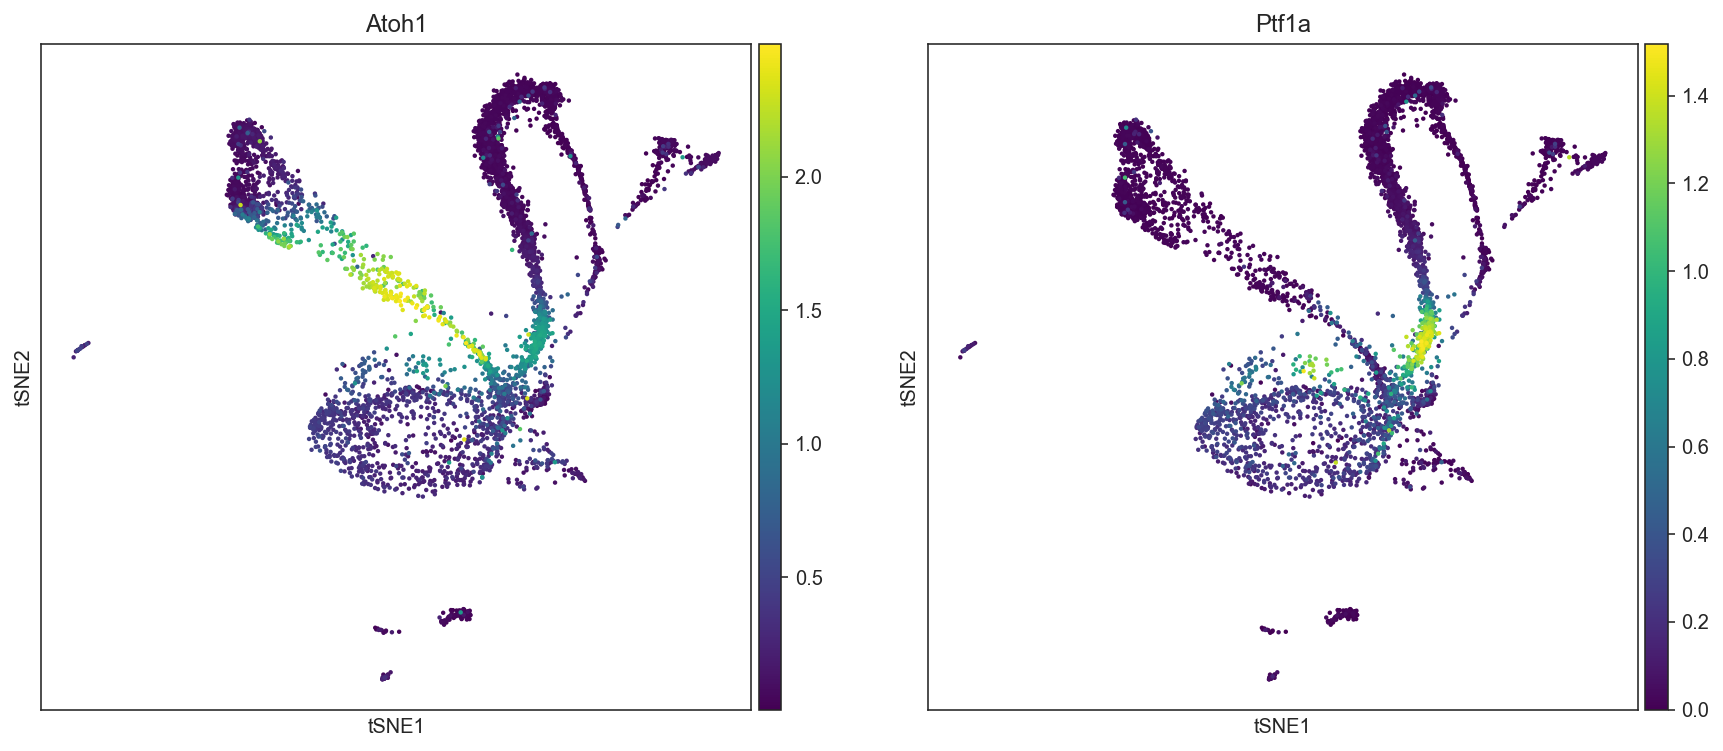

In [116]:
plt.rcParams["figure.figsize"] = [6.4,6]
sc.pl.tsne(oracle.adata, color=['Atoh1','Ptf1a'],
                 layer="imputed_count", use_raw=False, cmap="viridis", save="_Atoh1_KI")

In [117]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

fitting GRN again...
calculating GRN in CN_Th



genes_in_gem: 3000
models made for 808 genes
calculating GRN in CN_early1



genes_in_gem: 3000
models made for 759 genes
calculating GRN in CN_early2



genes_in_gem: 3000
models made for 827 genes
calculating GRN in CN_gaba



genes_in_gem: 3000
models made for 835 genes
calculating GRN in CN_late



genes_in_gem: 3000
models made for 798 genes
calculating GRN in Endothelium



genes_in_gem: 3000
models made for 964 genes
calculating GRN in Eryth



genes_in_gem: 3000
models made for 615 genes
calculating GRN in GABA_Pre



genes_in_gem: 3000
models made for 741 genes
calculating GRN in GABA_Pro



genes_in_gem: 3000
models made for 779 genes
calculating GRN in IN



genes_in_gem: 3000
models made for 714 genes
calculating GRN in Leptomeningeal cell



genes_in_gem: 3000
models made for 824 genes
calculating GRN in Mes.Isl1



genes_in_gem: 3000
models made for 773 genes
calculating GRN in Microglia



genes_in_gem: 3000
models made for 802 genes
calculating GRN in NPC



genes_in_gem: 3000
models made for 813 genes
calculating GRN in NPC_cyc



genes_in_gem: 3000
models made for 795 genes
calculating GRN in NPCa



genes_in_gem: 3000
models made for 811 genes
calculating GRN in PC



genes_in_gem: 3000
models made for 811 genes
calculating GRN in PTZ



genes_in_gem: 3000
models made for 792 genes
calculating GRN in Pericytes



genes_in_gem: 3000
models made for 846 genes
calculating GRN in RL



genes_in_gem: 3000
models made for 800 genes
calculating GRN in X_Otp



genes_in_gem: 3000
models made for 837 genes
calculating GRN in X_Otp_Pre



genes_in_gem: 3000
models made for 760 genes
calculating GRN in X_Tlx3



genes_in_gem: 3000
models made for 833 genes


To simulate Atoh1-Ptf1a KI, which will abolish Ptf1a expression, we set Ptf1a expression level to 0.

In [118]:
level=sc.get.obs_df(oracle.adata, keys=['Ptf1a'], layer="imputed_count").max()['Ptf1a']
oracle.simulate_shift(perturb_condition={'Atoh1': level, 'Ptf1a':0.0},
                      n_propagation=5)

In [119]:
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200, knn_random=True, sampled_fraction=0.5)

# Calculate embedding 
oracle.calculate_embedding_shift(sigma_corr = 0.05)

# Calculate global trend of cell transition
oracle.calculate_grid_arrows(smooth=0.8, steps=(40, 40), n_neighbors=300)

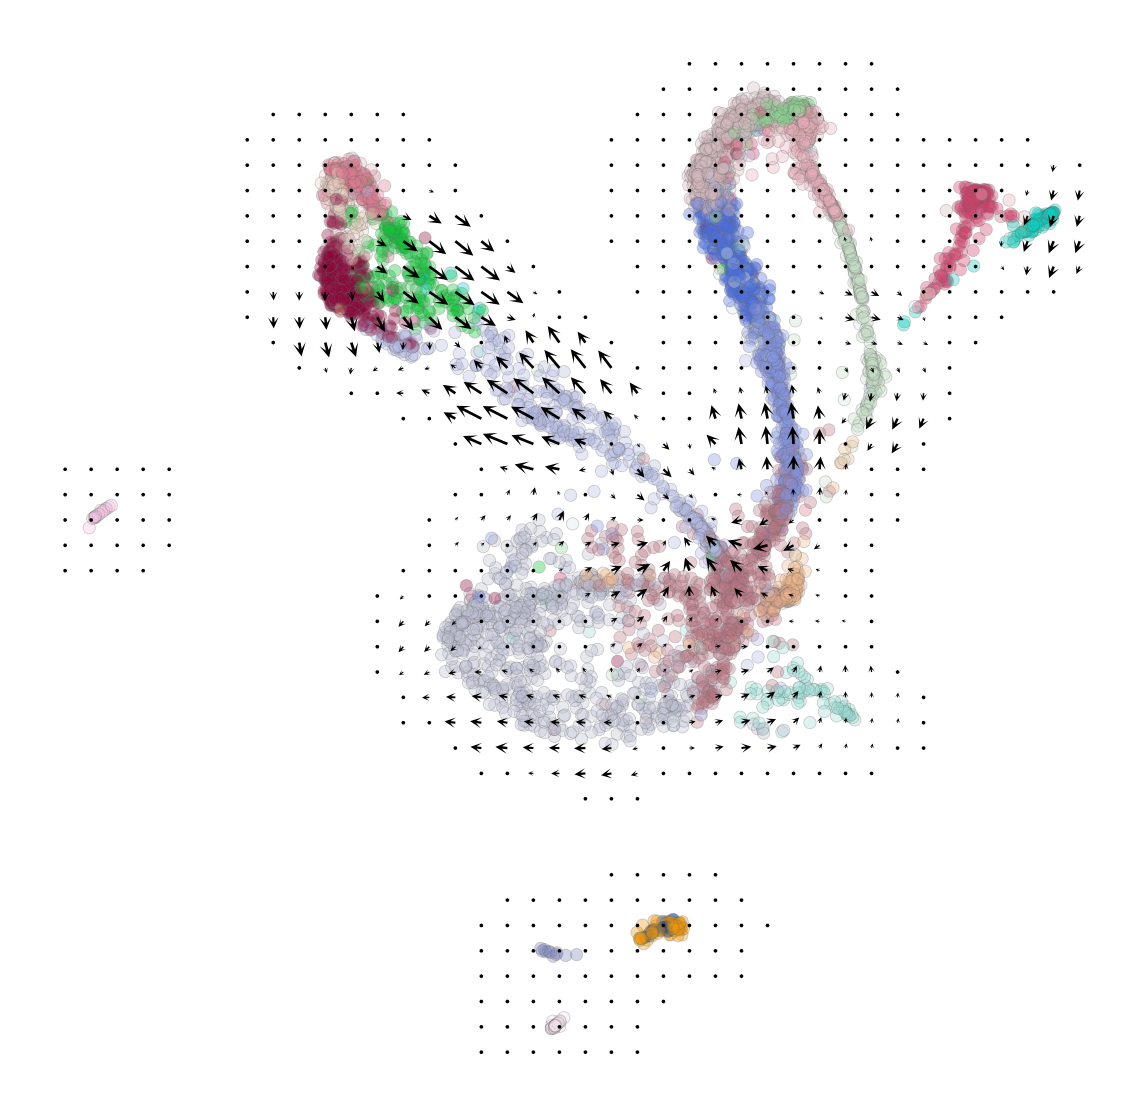

In [120]:
# Plot whole graph
plt.figure(None,(10,10))
oracle.plot_grid_arrows(quiver_scale=2.0,
                        scatter_kwargs_dict={"alpha":0.35, "lw":0.35, 
                                              "edgecolor":"0.4", "s":38, 
                                              "rasterized":True},
                        min_mass=0.015, angles='xy', scale_units='xy',
                        headaxislength=2.75,
                        headlength=5, headwidth=4.8, minlength=1.5,
                        plot_random=False, scale_type="relative")
plt.savefig(f"{save_folder}/vectorfield_{goi}_ectopic.pdf", transparent=True)

In [121]:
%%time
oracle.run_markov_chain_simulation(n_steps=200, n_duplication=5)

CPU times: user 4.22 s, sys: 61.2 ms, total: 4.28 s
Wall time: 4.06 s


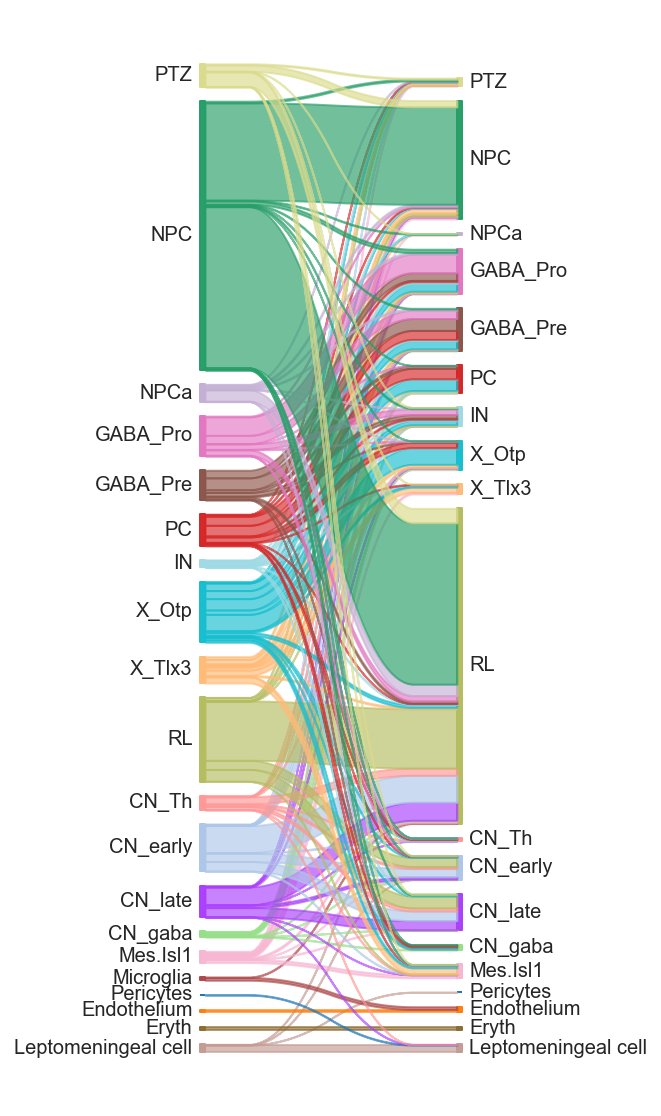

In [122]:
cl = "cellGroup"
order = ["PTZ",'NPC', 'NPCa','GABA_Pro', 'GABA_Pre', 'PC', 'IN', 'X_Otp', 'X_Otp_Pre', 'X_Tlx3','RL','CN_Th', 'CN_early', 'CN_late','CN_gaba', 'Mes.Isl1', 'Microglia', 'Pericytes','Endothelium', 'Eryth', 'Leptomeningeal cell']

plt.figure(figsize=[5,10])
plt.subplots_adjust(left=0.3, right=0.7)
oracle.plot_mc_resutls_as_sankey(cluster_use=cl, start=0, end=100, order=order)
plt.savefig(f"{save_folder}/simulation/mcmc_Atoh1-ectopic.pdf")

# Simulate Ptf1a KI into the Atoh1 locus

In [123]:
adata=sc.read("data/E12_GOF_Ptf1a.h5ad")

In [124]:
oracle = co.Oracle()

oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="cellType",
                                   embedding_name="X_tsne")
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=TFinfo_df)

31


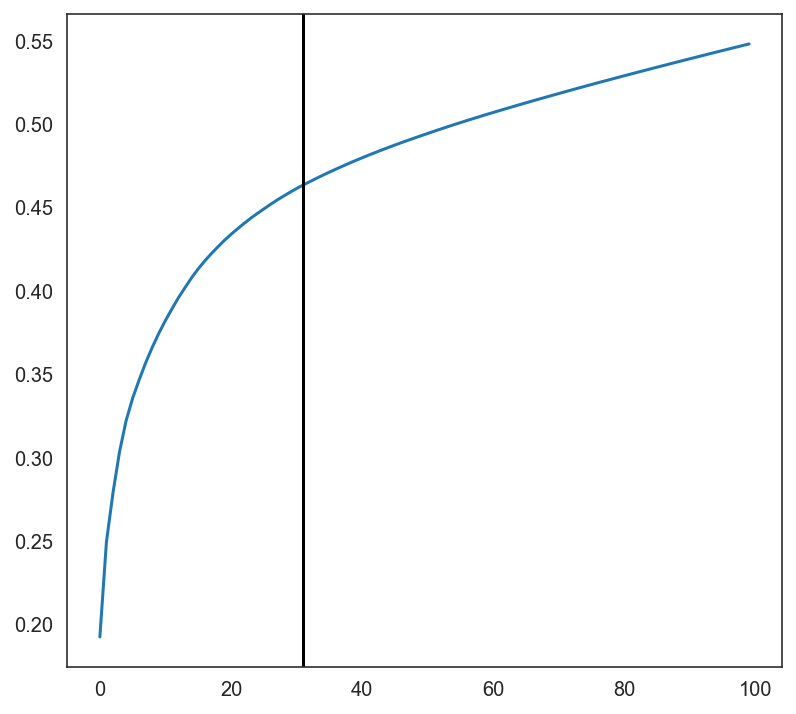

In [125]:
# Perform PCA
oracle.perform_PCA()
# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
print(n_comps)
n_comps = min(n_comps, 50)
n_cell = oracle.adata.shape[0]
k = int(0.025*n_cell)

In [126]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

As shown in the following output, Ptf1a is now ectopically expressed in the Atoh1 domain.

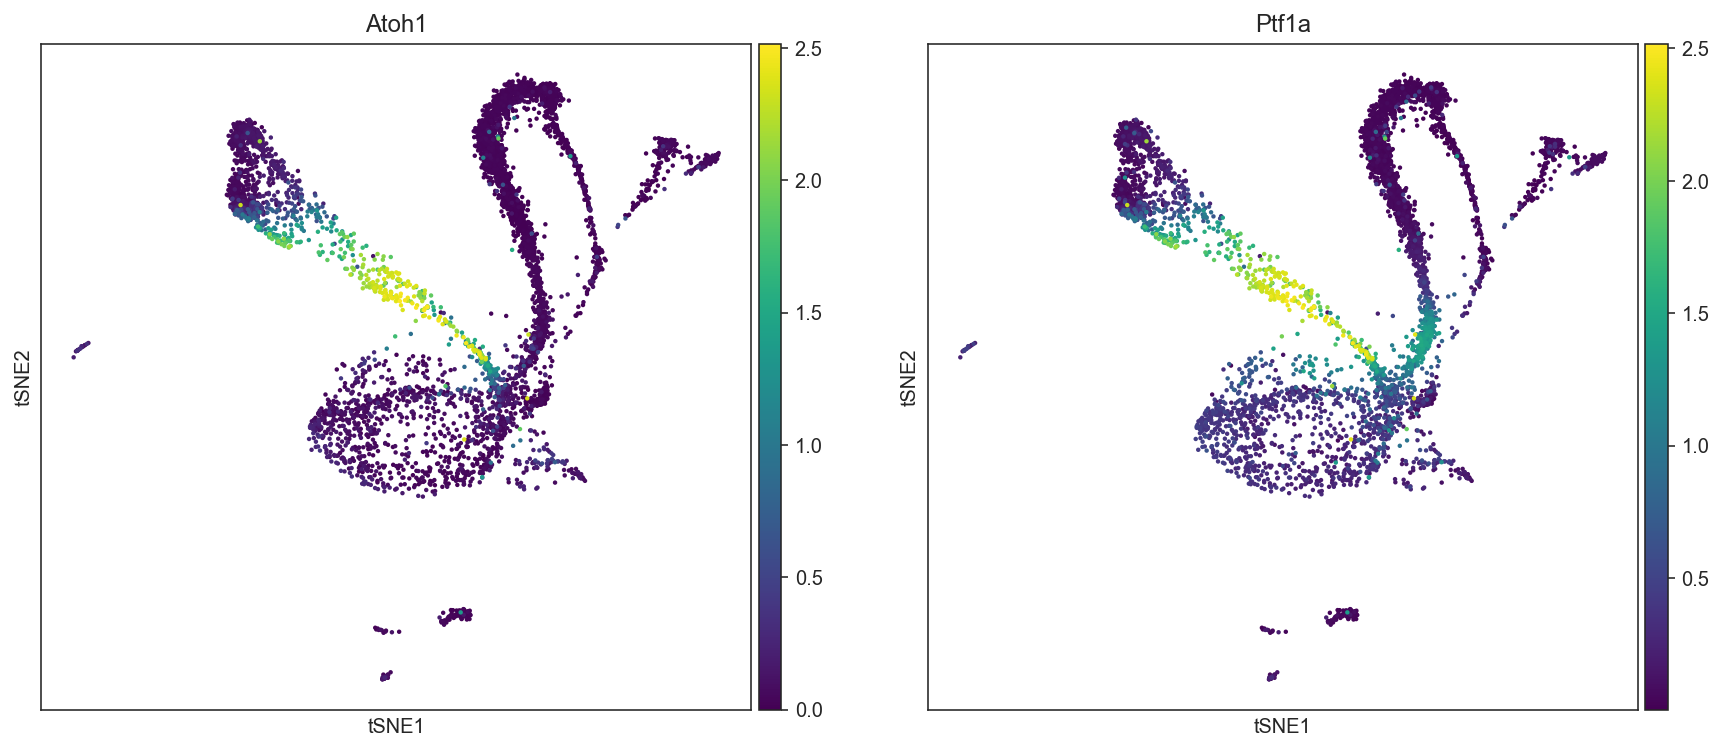

In [127]:
plt.rcParams["figure.figsize"] = [6.4,6]
sc.pl.tsne(oracle.adata, color=['Atoh1','Ptf1a'],
                 layer="imputed_count", use_raw=False, cmap="viridis", save="_Ptf1a_KI")

In [128]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

fitting GRN again...
calculating GRN in CN_Th



genes_in_gem: 3000
models made for 808 genes
calculating GRN in CN_early1



genes_in_gem: 3000
models made for 759 genes
calculating GRN in CN_early2



genes_in_gem: 3000
models made for 827 genes
calculating GRN in CN_gaba



genes_in_gem: 3000
models made for 835 genes
calculating GRN in CN_late



genes_in_gem: 3000
models made for 798 genes
calculating GRN in Endothelium



genes_in_gem: 3000
models made for 964 genes
calculating GRN in Eryth



genes_in_gem: 3000
models made for 615 genes
calculating GRN in GABA_Pre



genes_in_gem: 3000
models made for 741 genes
calculating GRN in GABA_Pro



genes_in_gem: 3000
models made for 779 genes
calculating GRN in IN



genes_in_gem: 3000
models made for 714 genes
calculating GRN in Leptomeningeal cell



genes_in_gem: 3000
models made for 824 genes
calculating GRN in Mes.Isl1



genes_in_gem: 3000
models made for 773 genes
calculating GRN in Microglia



genes_in_gem: 3000
models made for 802 genes
calculating GRN in NPC



genes_in_gem: 3000
models made for 813 genes
calculating GRN in NPC_cyc



genes_in_gem: 3000
models made for 795 genes
calculating GRN in NPCa



genes_in_gem: 3000
models made for 811 genes
calculating GRN in PC



genes_in_gem: 3000
models made for 811 genes
calculating GRN in PTZ



genes_in_gem: 3000
models made for 792 genes
calculating GRN in Pericytes



genes_in_gem: 3000
models made for 846 genes
calculating GRN in RL



genes_in_gem: 3000
models made for 800 genes
calculating GRN in X_Otp



genes_in_gem: 3000
models made for 837 genes
calculating GRN in X_Otp_Pre



genes_in_gem: 3000
models made for 760 genes
calculating GRN in X_Tlx3



genes_in_gem: 3000
models made for 833 genes


In [129]:
level=sc.get.obs_df(oracle.adata, keys=['Atoh1'], layer="imputed_count").max()['Atoh1']
oracle.simulate_shift(perturb_condition={'Atoh1': 0.0, 'Ptf1a':level},
                      n_propagation=5)

In [130]:
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200, knn_random=True, sampled_fraction=0.5)

# Calculate embedding 
oracle.calculate_embedding_shift(sigma_corr = 0.05)

# Calculate global trend of cell transition
oracle.calculate_grid_arrows(smooth=0.8, steps=(40, 40), n_neighbors=300)

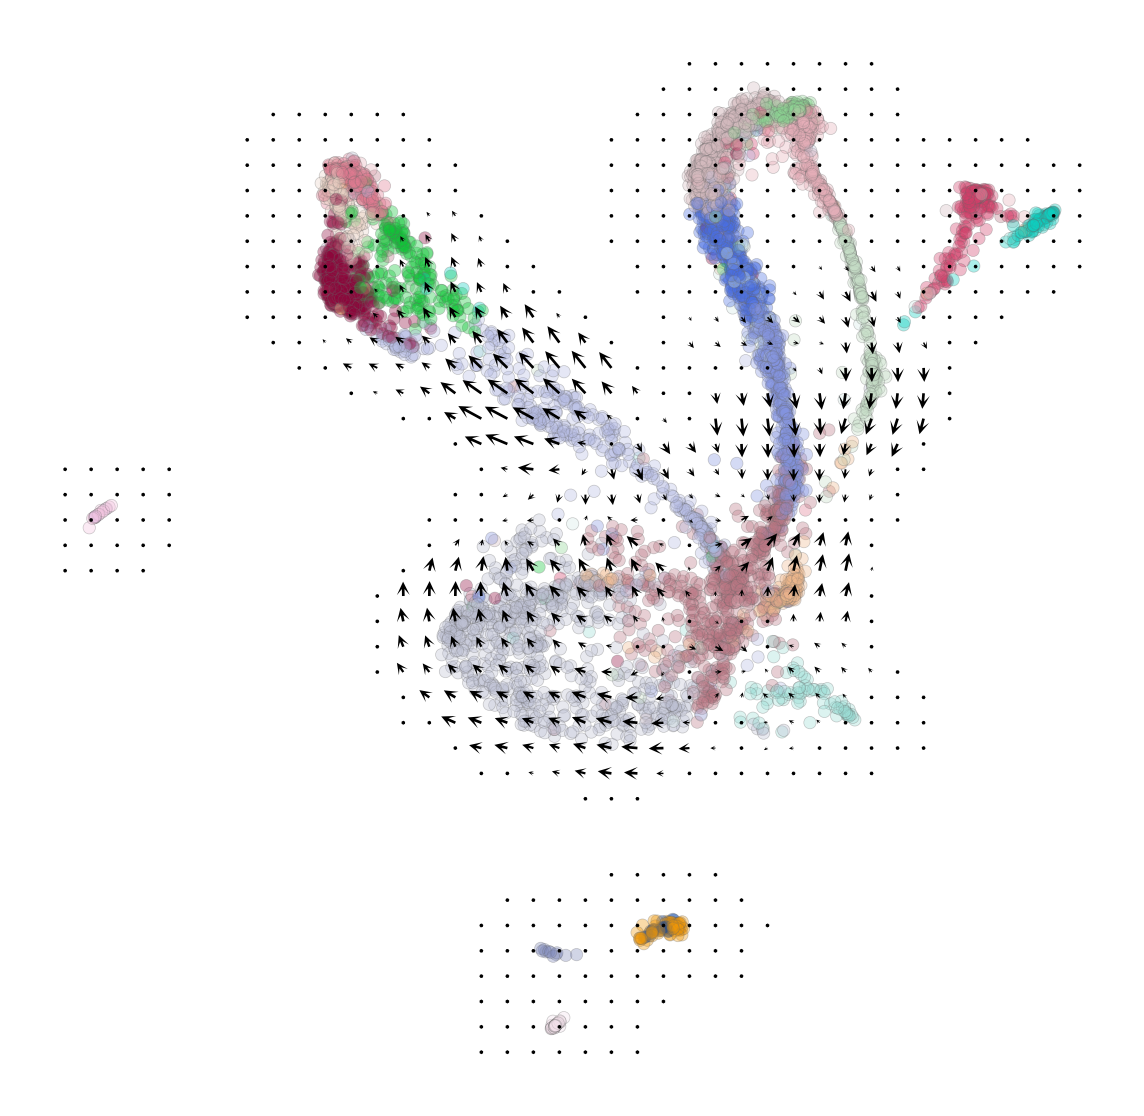

In [131]:
# Plot whole graph
plt.figure(None,(10,10))
oracle.plot_grid_arrows(quiver_scale=2.0,
                        scatter_kwargs_dict={"alpha":0.35, "lw":0.35, 
                                              "edgecolor":"0.4", "s":38, 
                                              "rasterized":True},
                        min_mass=0.015, angles='xy', scale_units='xy',
                        headaxislength=2.75,
                        headlength=5, headwidth=4.8, minlength=1.5,
                        plot_random=False, scale_type="relative")
plt.savefig(f"{save_folder}/vectorfield_Ptf1a_ectopic.pdf", transparent=True)

In [132]:
%%time
oracle.run_markov_chain_simulation(n_steps=200, n_duplication=5)

CPU times: user 4.72 s, sys: 71.1 ms, total: 4.79 s
Wall time: 4.57 s


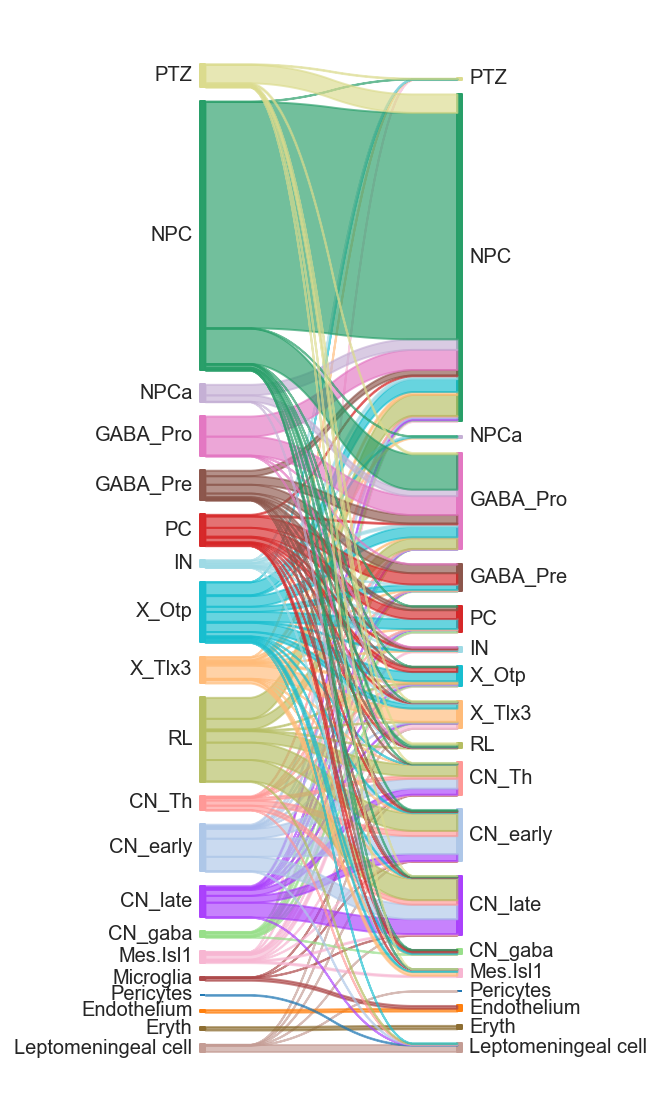

In [133]:
plt.figure(figsize=[5,10])
plt.subplots_adjust(left=0.3, right=0.7)
oracle.plot_mc_resutls_as_sankey(cluster_use=cl, start=0, end=100, order=order)
plt.savefig(f"{save_folder}/simulation/mcmc_Ptf1a_ectopic.pdf")